In [66]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd

In [67]:
data_dir = r'C:/Users/bryn0/DHSData/'
files = os.listdir(data_dir)
labels = pd.read_csv('stage1_labels.csv')

In [68]:
#Check to see whether io functions are working
sample_file = '1bdbd76b8e1c2a8651262f857ed5f046.a3daps'
sample_header = iof.read_header(os.path.join(data_dir,sample_file))
sample_sample = iof.read_data(os.path.join(data_dir,sample_file))

See what a sample header looks like

In [69]:
pp.pprint(sample_header)

{'adc_max_voltage': array([ 1.10000002], dtype=float32),
 'adc_min_voltage': array([-1.10000002], dtype=float32),
 'adc_type': array([17], dtype=int16),
 'ahis_software_version': array([ 7.0999999], dtype=float32),
 'avg_data_value': array([ 8992.40625], dtype=float32),
 'azimuth_offset_angle': array([ 0.], dtype=float32),
 'band_width': array([ 30058.70898438], dtype=float32),
 'comments1': b'                                                            '
              b'                    ',
 'comments2': b'                                                            '
              b'                    ',
 'config_type': array([2], dtype=int16),
 'data_scale_factor': array([  9.26860866e-06], dtype=float32),
 'data_storage_order': array([9], dtype=int16),
 'data_type': array([5], dtype=int16),
 'data_units': array([0], dtype=int16),
 'date_modified': b'',
 'date_processed': b'',
 'depth_recon': array([ 0.], dtype=float32),
 'edge_weighting': array([0], dtype=uint16),
 'elevation_offs

In [70]:
print(sample_sample.shape)

(512, 660, 64)


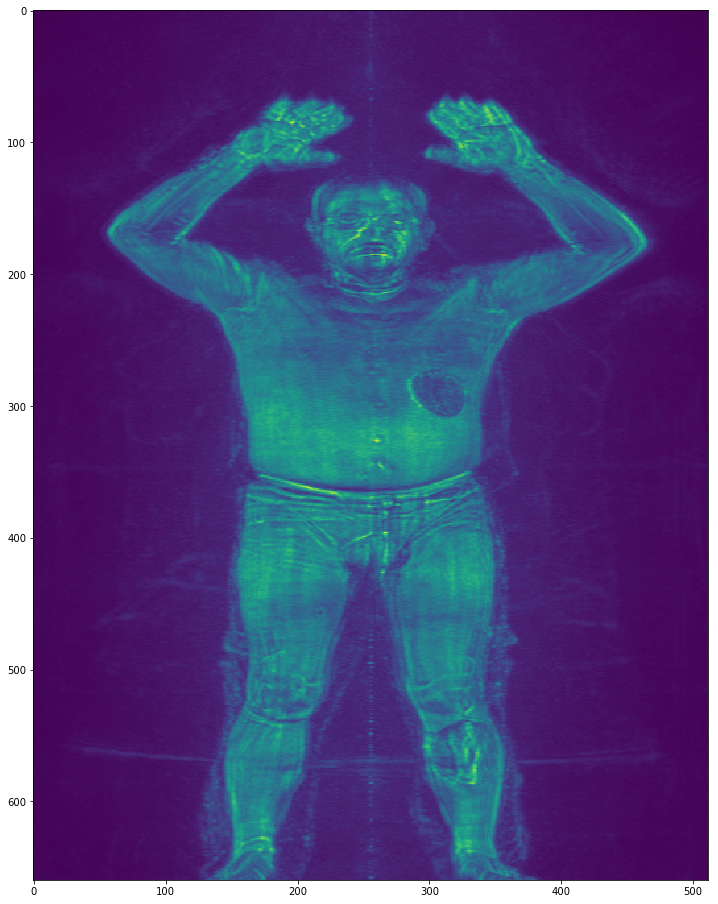

In [20]:
iof.plot_image(os.path.join(data_dir,sample_file))

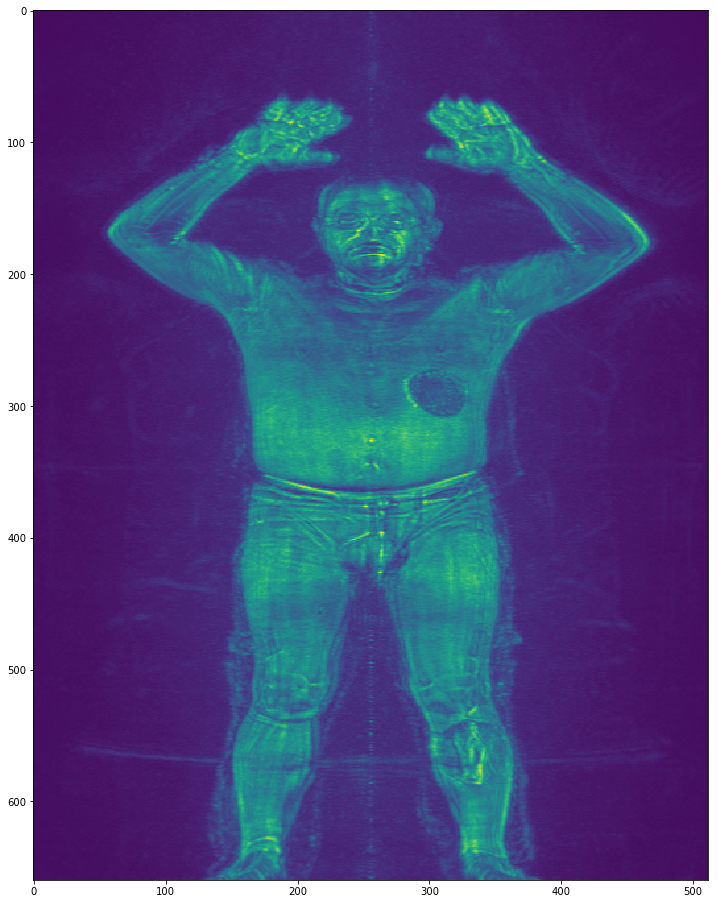

In [84]:
#Shift and normalize data
sample_min = np.amin(sample_sample)
sample_max = np.amax(sample_sample)
sample_shifted = (sample_sample-sample_min)/(sample_max-sample_min)*255
sample_average = np.mean(sample_shifted)
sample_std = np.std(sample_shifted)
sample_norm = (sample_shifted-sample_average)/sample_std
data = sample_norm
fig = matplotlib.pyplot.figure(figsize = (16,16))
ax = fig.add_subplot(111)
img = ax.imshow(np.flipud(data[:,:,0].transpose()),cmap='viridis')

In [16]:
locs = [True if sample_file.replace('.a3daps','') in i else False for i in labels['Id']]
print(labels[locs])
#What do threats look like

                                           Id  Probability
1938   1bdbd76b8e1c2a8651262f857ed5f046_Zone1            0
1939  1bdbd76b8e1c2a8651262f857ed5f046_Zone10            0
1940  1bdbd76b8e1c2a8651262f857ed5f046_Zone11            0
1941  1bdbd76b8e1c2a8651262f857ed5f046_Zone12            0
1942  1bdbd76b8e1c2a8651262f857ed5f046_Zone13            0
1943  1bdbd76b8e1c2a8651262f857ed5f046_Zone14            1
1944  1bdbd76b8e1c2a8651262f857ed5f046_Zone15            1
1945  1bdbd76b8e1c2a8651262f857ed5f046_Zone16            0
1946  1bdbd76b8e1c2a8651262f857ed5f046_Zone17            0
1947   1bdbd76b8e1c2a8651262f857ed5f046_Zone2            0
1948   1bdbd76b8e1c2a8651262f857ed5f046_Zone3            0
1949   1bdbd76b8e1c2a8651262f857ed5f046_Zone4            0
1950   1bdbd76b8e1c2a8651262f857ed5f046_Zone5            0
1951   1bdbd76b8e1c2a8651262f857ed5f046_Zone6            0
1952   1bdbd76b8e1c2a8651262f857ed5f046_Zone7            1
1953   1bdbd76b8e1c2a8651262f857ed5f046_Zone8           

In [27]:
#We are going to make this a multinomial regression exercise 
#Let's merge the data sets
labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])]
labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
#Prepare the dataset 
#Create a dataset that is more tractable for analysis in pandas
labels_merged_flat = []
for i in labels_merged:
    temp = []
    temp.append(i[0])
    for j in range(len(i[1])):
        temp.append(i[1][j])
    labels_merged_flat.append(temp)
labels_merged_pd = pd.DataFrame(labels_merged_flat)     
labels_merged_pd.head()
labels_merged_pd.shape

Several ideas for reducing the dimensionality of the data. 
1. One might be to unfold the 3d image into a 2d projection that we can then use a convolutional 2d method and recycle code from last time. 
2. We might convert the data into cylindrical coordinates to at least make a point have a fixed position in space before loading it into a 3d convolution
We should also try several techniques for multi-label classification.  Ada-Boost might be appropriate here.  Neural network likely to require much more data. Before moving on to try a neural network, we should plot the learning curve of logistic regressions trained on the different zones. 



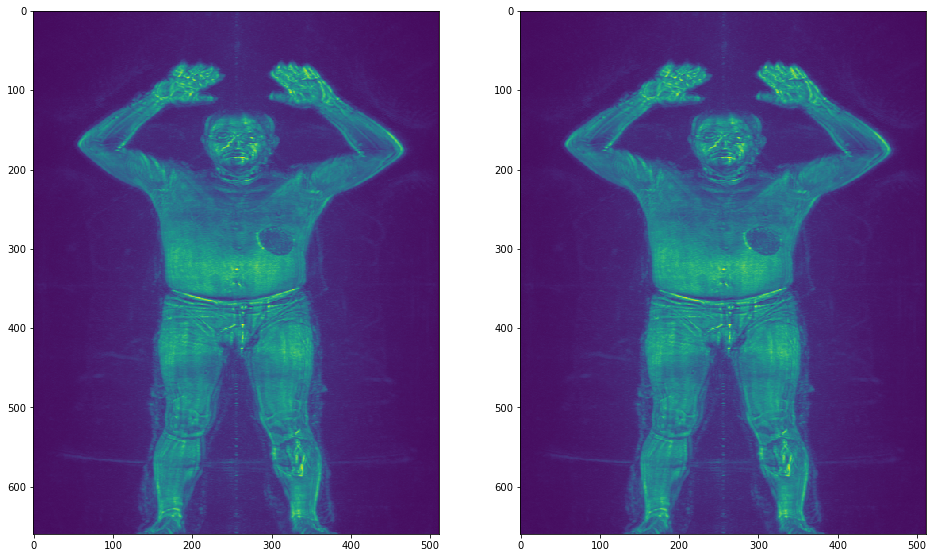

In [47]:
#Check normalized sample against original
print(sample_sample)
print(sample_norm)
#Plot data
fig = matplotlib.pyplot.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.imshow(np.flipud(sample_sample[:,:,0].transpose()), cmap = 'viridis')
ax2.imshow(np.flipud(sample_norm[:,:,0].transpose()), cmap = 'viridis')

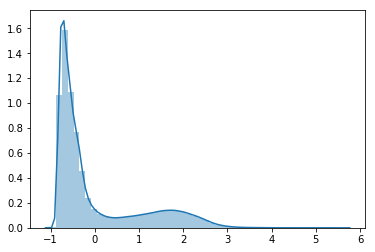

In [48]:
sns.distplot(sample_norm.flatten())

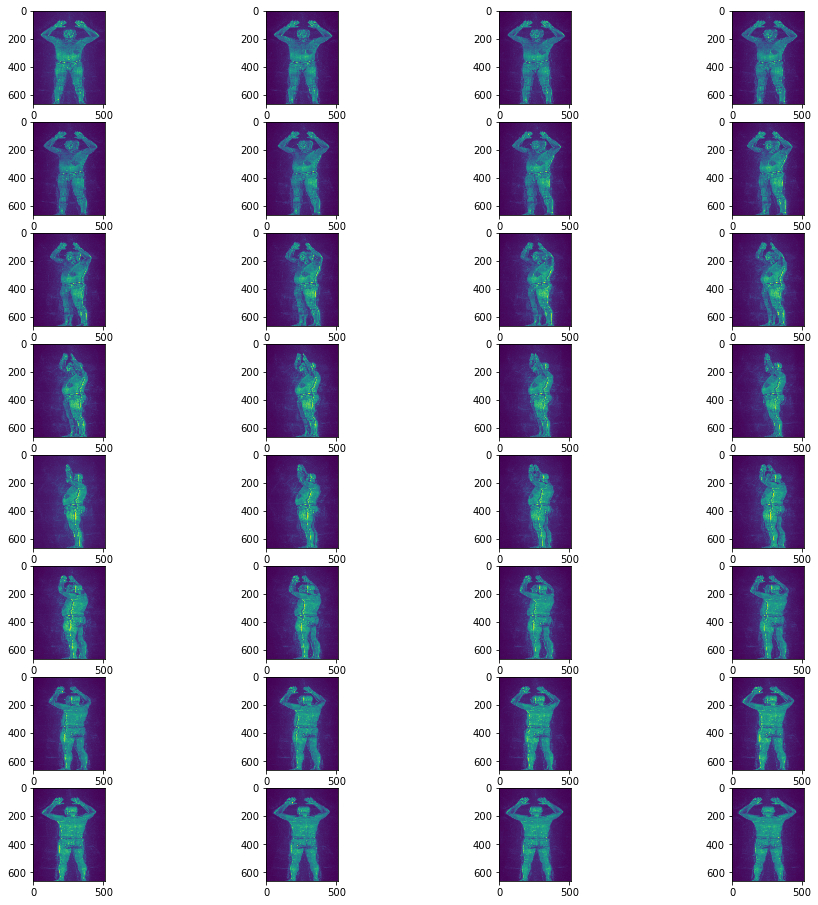

In [96]:
#Show image from different angles
fig, axarr = plt.subplots(8,4,figsize=(16,16))
k = 0
for i in range(8):
    for j in range(4):
        axarr[i][j].imshow(np.flipud(sample_sample[:,:,k].transpose()), cmap = 'viridis')
        k += 1

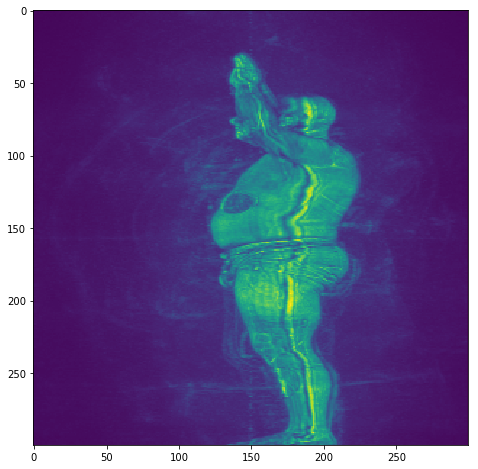

In [141]:
#Let's try resizing the images for a 3d convolution
import cv2 

resized = cv2.resize(sample_norm[:,:,16],dsize = (300,300) )
fig = matplotlib.pyplot.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.imshow(np.flipud(resized.transpose()), cmap = 'viridis')

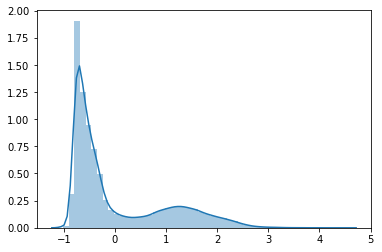

In [127]:
sns.distplot(sample_norm[:,:,0].flatten())

In [140]:
#Get stats
print("Shape of data:{}".format(labels_merged_pd.shape))
df_melted = pd.melt(labels_merged_pd,id_vars = (0),var_name = 'Zone',value_name = 'Probability')
df_summary = df_melted.groupby('Zone')['Probability'].agg(['sum','count'])
df_summary['Pct'] = df_summary['sum']/df_summary['count']
df_summary.sort_values('Pct',axis=0,ascending=False,inplace=True)
df_summary

Shape of data:(1147, 18)


,sum,count,Pct
Zone,,,
1,133,1147,0.115955
2,126,1147,0.109852
8,124,1147,0.108108
14,122,1147,0.106364
15,118,1147,0.102877
6,116,1147,0.101133
11,116,1147,0.101133
13,110,1147,0.095902
16,109,1147,0.095031


In [ ]:
#Move on to data set preparation 